In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from os.path import basename, dirname
from shutil import copyfile

import json
from collections import OrderedDict

import torch

In [4]:
os.chdir("..")

In [5]:
from transformers import FSMTForConditionalGeneration
from da.hugging_fseq_tokenizer import HuggingFseqTokenizer
from da.convert_fsmt_simple_checkpoint_to_pytorch import convert_fsmt_simple_checkpoint_to_pytorch

In [6]:
from types import MethodType

from da.greedy_search_interpret import greedy_search_interpret

In [7]:
exp_path = "experiments/concat"
fseq_checkpoint_path = f"{exp_path}/checkpoint_best.pt"
save_dir = f"{exp_path}/hf"
data_path = "data-prep/bin-data-en-et-base/"
spm_model_file = "data-prep/preproc-models/syscl-en-et.model"

In [8]:
tokenizer_hf = HuggingFseqTokenizer.from_pretrained(save_dir)
model_hf = FSMTForConditionalGeneration.from_pretrained(save_dir)

In [9]:
model_hf.greedy_search = MethodType(greedy_search_interpret, model_hf)

# Plot

In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline

In [11]:
np.random.seed(42)

In [12]:
lines = {}

with open("data-prep/cleaned/cl-Europarl.en-et.docs.dev.en") as f:
    lines["Europarl"] = [l[:-2] for l in f.readlines()]

with open("data-prep/cleaned/cl-EMEA.en-et.docs.dev.en") as f:
    lines["EMEA"] = [l[:-2] for l in f.readlines()]

with open("data-prep/cleaned/cl-JRC-Acquis.en-et.docs.dev.en") as f:
    lines["JRC"] = [l[:-2] for l in f.readlines()]

with open("data-prep/cleaned/cl-OpenSubtitles.en-et.docs.dev.en") as f:
    lines["OpenSubtitles"] = [l[:-2] for l in f.readlines()]    

In [62]:
def encode_sentence(src):
    # tok
    src = tokenizer_hf.encode_plus(
        src,
        padding="longest", 
        return_tensors="pt",
        return_token_type_ids=False,
        return_attention_mask=True
    )
    
    # res
    res = model_hf.generate(**src,
                       #return_dict=True,
                       output_hidden_states=True,
                       output_attentions=True,
                       do_sample=False,
                       num_beams=1)
    
    he = [r.detach().numpy() for r in res['encoder_hidden_states']]
    hd = [r.detach().numpy() for r in res['decoder_hidden_states']]

    return he, hd

In [66]:
def encode_sentences(srcs, num=None):
    hiddens_enc = []
    hiddens_dec = []
    
    if num == None:
        num = len(srcs)

    for src in srcs[0:num]:
        he, hd = encode_sentence(src)
        
        hiddens_enc.append(he)
        hiddens_dec.append(hd)

    return hiddens_enc, hiddens_dec

In [67]:
NUM_EXAMPLES = 300

In [68]:
%%time

# embed
hiddens_enc = {}
hiddens_dec = {}

for k, v in lines.items():
    print(k)
    hiddens_enc[k], hiddens_dec[k] = encode_sentences(v, NUM_EXAMPLES)

Europarl
EMEA
JRC
OpenSubtitles
CPU times: user 25min 51s, sys: 1.85 s, total: 25min 53s
Wall time: 2min 35s


In [73]:
def compute_sent_reps(hiddens):
    # hiddens: N x L x 1 x sen_len x emb_size
    for i, n in enumerate(hiddens):
        for j, l in enumerate(n):
            hiddens[i][j] = l.squeeze(0).mean(0)

In [74]:
for k, v in hiddens_enc.items():
    compute_sent_reps(v)
    
for k, v in hiddens_dec.items():
    compute_sent_reps(v)
    

In [75]:
for k, v in hiddens_enc.items():
    hiddens_enc[k] = list(map(list, zip(*v)))
    
for k, v in hiddens_dec.items():
    hiddens_dec[k] = list(map(list, zip(*v)))

In [80]:
layer_reps_enc = {}
layers_enc = [0,1,2,3,4,5,6]
for l in layers_enc:
    reps = np.concatenate([
        hiddens_enc["Europarl"][l], 
        hiddens_enc["EMEA"][l], 
        hiddens_enc["JRC"][l],
        hiddens_enc["OpenSubtitles"][l],
    ])

    layer_reps_enc[l] = reps

labels = ["Europarl"]*NUM_EXAMPLES + ["EMEA"]*NUM_EXAMPLES + ["JRC"]*NUM_EXAMPLES + ["OpenSubtitles"]*NUM_EXAMPLES

In [81]:
layer_reps_dec = {}
layers_dec = [0,1,2,3,4,5]
for l in layers_dec:
    reps = np.concatenate([
        hiddens_dec["Europarl"][l], 
        hiddens_dec["EMEA"][l], 
        hiddens_dec["JRC"][l],
        hiddens_dec["OpenSubtitles"][l],
    ])

    layer_reps_dec[l] = reps

labels = ["Europarl"]*NUM_EXAMPLES + ["EMEA"]*NUM_EXAMPLES + ["JRC"]*NUM_EXAMPLES + ["OpenSubtitles"]*NUM_EXAMPLES

In [82]:
%%time

reps_tsne_enc = {}
for k, r in layer_reps_enc.items():
    reps_tsne_enc[k] = TSNE(
        n_components=2, 
        verbose=0, 
        n_jobs=-1, 
        metric='cosine', 
        perplexity=30, 
        init='pca').fit_transform(r)

CPU times: user 2min 4s, sys: 308 ms, total: 2min 4s
Wall time: 13 s


In [83]:
%%time

reps_tsne_dec = {}
for k, r in layer_reps_dec.items():
    reps_tsne_dec[k] = TSNE(
        n_components=2, 
        verbose=0, 
        n_jobs=-1, 
        metric='cosine', 
        perplexity=30, 
        init='pca').fit_transform(r)

CPU times: user 1min 51s, sys: 188 ms, total: 1min 52s
Wall time: 11.6 s


In [84]:
def to_df(reps, labels):
    reps = pd.DataFrame(reps)
    reps['domain'] = labels
    return reps.sample(frac=1)

#### Ecnoder

<ipython-input-91-63c92fa3f115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-91-63c92fa3f115>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-91-63c92fa3f115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-91-63c92fa3f115>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-91-63c92fa3f115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-91-63c92fa3f115>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-91-63c92fa3f115>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")

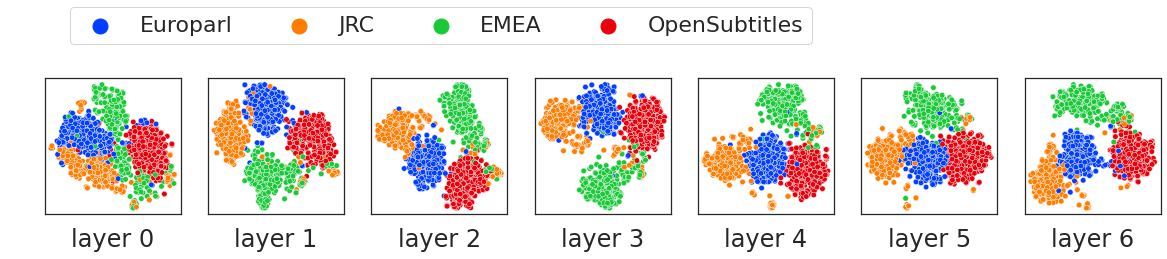

In [91]:
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

fig, axs = plt.subplots(1, len(layers_enc), figsize=(20,2.5))

for ind, l in enumerate(layers_enc):
    df = to_df(reps_tsne_enc[l], labels).sample(frac=1)
    sns.scatterplot(ax = axs[ind], x=df[0], y=df[1],
                    hue=df['domain'], hue_order=["Europarl", "JRC", "EMEA", "OpenSubtitles"], 
                    s=30)
    
#     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
#        .map(plt.scatter, 0, 1) \
#        .add_legend()
    
    axs[ind].set_xticklabels(" ")
    axs[ind].set_yticklabels(" ")
    axs[ind].set_xlabel(f"layer {l}")
    axs[ind].set_ylabel(" ")    
    axs[ind].legend().set_visible(False)
    
    if ind == 0:
        pass
        #axs[ind].legend().set_visible(True)
        #axs[ind].legend
        #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
handles, ax_labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=2.5, bbox_to_anchor=(0.4,1.34))

#fig.savefig("plots/tsne_abstraction_pattern.pdf", bbox_inches='tight')

<ipython-input-95-2b8a6f239f5f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_yticklabels(" ")
<ipython-input-95-2b8a6f239f5f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ind].set_xticklabels(" ")

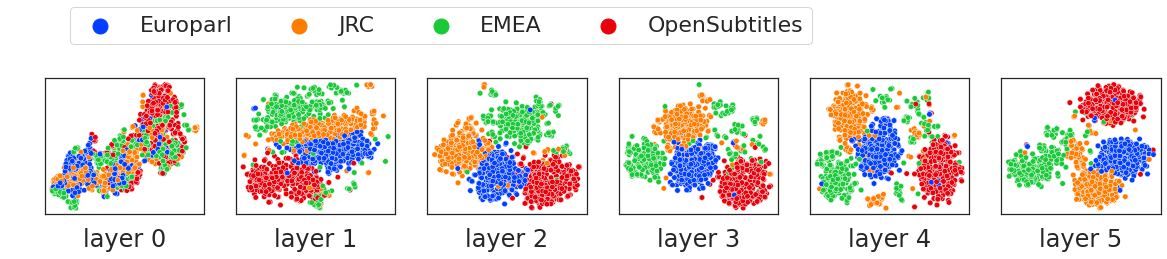

In [95]:
sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("bright")

fig, axs = plt.subplots(1, len(layers_dec), figsize=(20,2.5))

for ind, l in enumerate(layers_dec):
    df = to_df(reps_tsne_dec[l], labels).sample(frac=1)
    sns.scatterplot(ax = axs[ind], x=df[0], y=df[1],
                    hue=df['domain'], hue_order=["Europarl", "JRC", "EMEA", "OpenSubtitles"], 
                    s=30)
    
#     sns.FacetGrid(ax=axs[ind], data=df, hue="domain", size=6) \
#        .map(plt.scatter, 0, 1) \
#        .add_legend()
    
    axs[ind].set_xticklabels(" ")
    axs[ind].set_yticklabels(" ")
    axs[ind].set_xlabel(f"layer {l}")
    axs[ind].set_ylabel(" ")    
    axs[ind].legend().set_visible(False)
    
    if ind == 0:
        pass
        #axs[ind].legend().set_visible(True)
        #axs[ind].legend
        #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))
handles, ax_labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ax_labels, loc='upper center', ncol=6,  markerscale=2.5, bbox_to_anchor=(0.4,1.34))

#fig.savefig("plots/tsne_abstraction_pattern.pdf", bbox_inches='tight')

In [93]:
2+2

4